In [1]:
%matplotlib inline

import os

import matplotlib
import matplotlib.pyplot as pyplot
import geopandas as gpd
import numpy as np

from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.affinity import scale

import shapely.ops

from tile_units import TileUnit
from tile_units import TileShape
from tile_map import Tiling

In [2]:
def get_filename_label(path):
    fname = os.path.basename(path)
    return fname.partition("-")[0]

## Get the data

In [3]:
paths = ["../data/016383-GWR_fixbw-COVID_cases_per_1000persons__over_both_periods--BACKWARD_ELIM-round-8.gpkg"]

gwrs = [gpd.read_file(p) for p in paths]
for g in gwrs:
    g["ID"] = list(range(g.shape[0]))
    # g["NA_beta_classified"] = "not significant"

In [4]:
states = gpd.read_file("../data/0-gwr-states.gpkg")
states = states.dissolve(
    by = "STATE_FIPS")[["STATE", "geometry"]]

In [5]:
d = 50000
tile_inset = 1000
tiling_rotation = 15

## A hex 6 dissection

<AxesSubplot:>

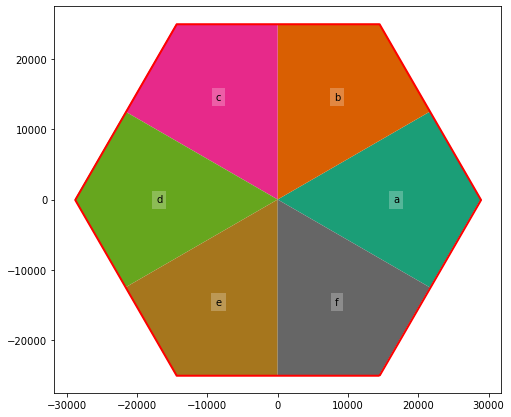

In [6]:
# make a base tile to start
hex_6_tile = TileUnit(tiling_type = "hex-dissection", n = 6,
                      spacing = d, crs = gwrs[0].crs)
hex_6_tile.plot()

Use it to tile the states

In [7]:
states_tiling = Tiling(hex_6_tile, states, id_var = "STATE")
states_hex6_layer = states_tiling.get_tiled_map(
    rotation = tiling_rotation, prioritise_tiles = True).tiled_map
states_hex6_layer.geometry = states_hex6_layer.geometry.buffer(
    1e-3, resolution = 1, join_style = 2)
states_hex6_layer = states_hex6_layer.dissolve(
        by = "STATE", as_index = False)
states_hex6_layer.geometry = states_hex6_layer.geometry.buffer(
    -1e-3, resolution = 1, join_style = 2)
# states_hex6_layer.plot(ec = "w")

Now tile the data map, but this time apply a tile margin.

In [8]:
hex6_tiling = Tiling(hex_6_tile, gwrs[0], id_var = "ID", 
                     tile_margin = tile_inset)
hex6_map = hex6_tiling.get_tiled_map(
    rotation = tiling_rotation, prioritise_tiles = True)

Make up variable and colourmap lookups

In [9]:
betas = [n for n in gwrs[0].columns if "_beta_classified" in n]
hex6_map.variables = dict(zip(list("abcde"), betas))
hex6_map.colourmaps =  dict(zip(
    betas, 5 * [{'associated with LESS covid': "#69A7CF",
                  'not significant': "#C7C7C7",
                  'associated with MORE covid': "#EF8A62"}]))
hex6_map.dpi = 150
hex6_map.figsize = (24, 18)

And make a map

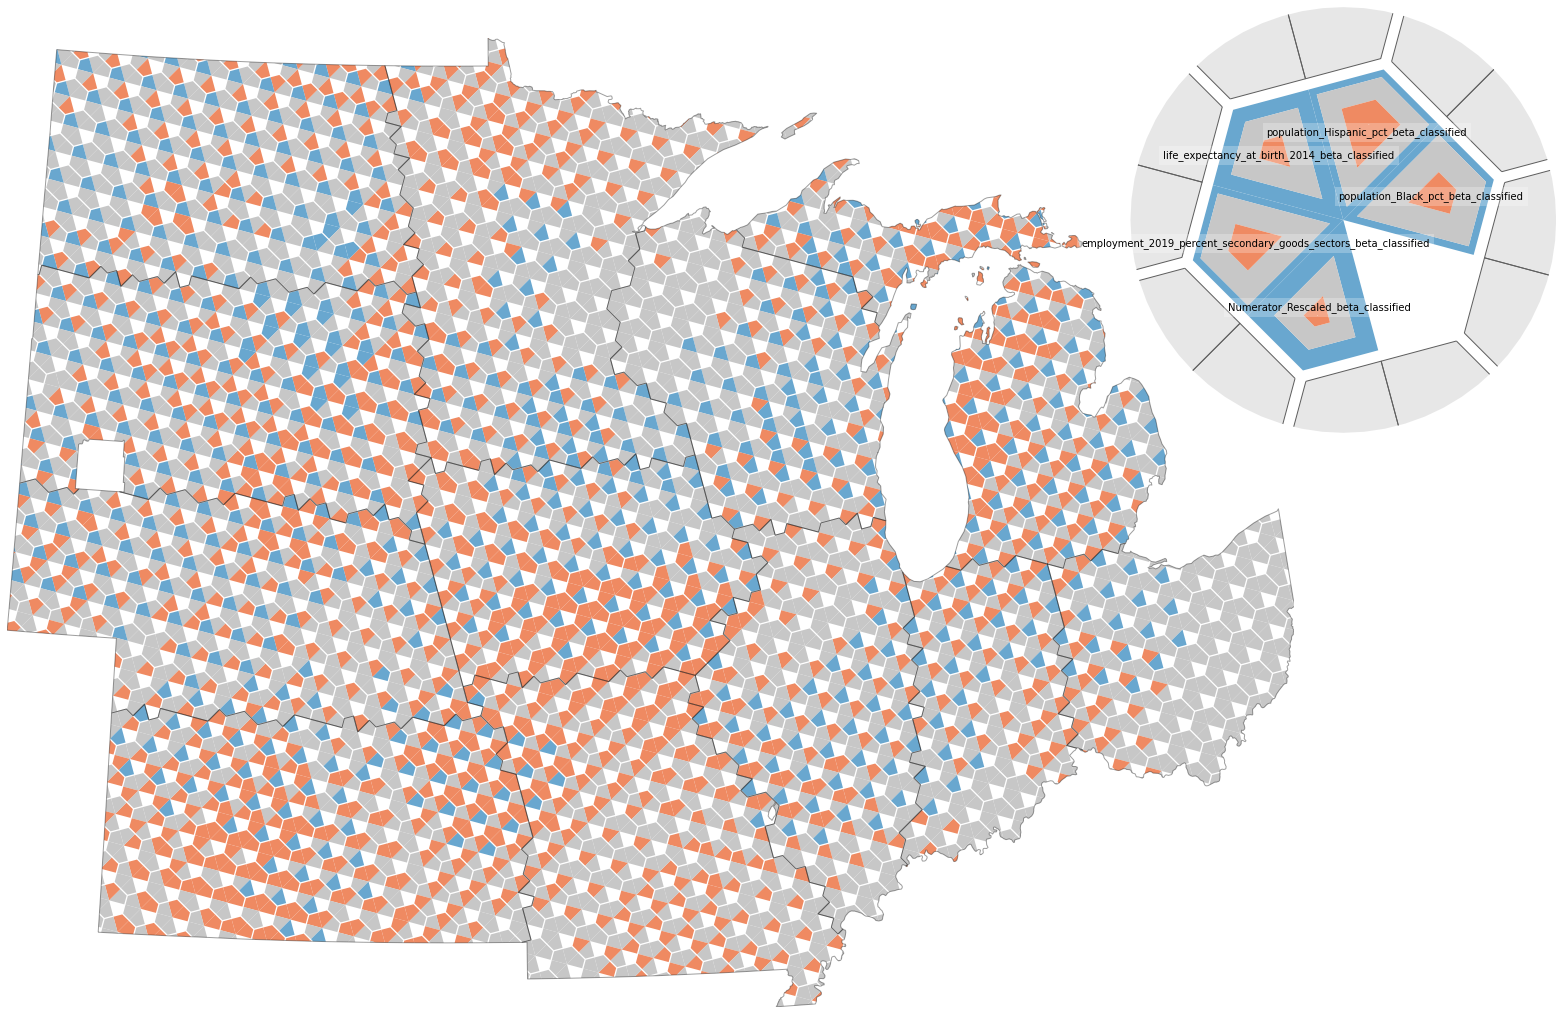

In [10]:
fig = hex6_map.render(
    legend_zoom = 1., legend_dx = -0.1, legend_dy = -0.1,
    use_ellipse = True, ellipse_magnification = 1)
states_hex6_layer.plot(ax = fig.get_axes()[0], fc = "#00000000", 
                       ec = "#00000060", lw = 1)

fig.savefig(f"hex_{get_filename_label(paths[0])}.pdf")